# Heartbeat Classification
## Implementation

In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from scipy.io import wavfile
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter,butter,resample
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from sklearn.metrics import classification_report

In [0]:
def load_data(path):
    frame=[]
    for filename in os.listdir(path):
        if filename[-3:]=='wav':
            frame.append(wavfile.read(path+filename))
    print('Data Importation Succeeded')
    return frame

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def data_framing(serie, nb_framing):
    while len(serie)<nb_framing:
        serie=np.concatenate((serie, serie), axis=None)
    return serie[0:nb_framing]

In [0]:
def load_and_process(path,label):
    list=load_data(path)
    X=[]
    for i in range(0,len(list)):
        processed_list=data_framing(
                       butter_bandpass_filter(
                       list[i][1],50,800,4000),50000)

        processed_list=resample(processed_list,782)
        processed_list=processed_list/max(abs(processed_list))
        X.append(processed_list)

    X=np.array(X)
    y=np.ones(X.shape[0])*label

    return X, y.astype(int)


In [24]:
rootpath='gdrive/My Drive/Colab Notebooks/Heartbeat_proj/'
X1,y1=load_and_process(rootpath+'data/Training B Normal/',0)
X2,y2=load_and_process(rootpath+'data/Btraining_murmur/',1)
X3,y3=load_and_process(rootpath+'data/Btraining_extrastole/',2)
print('Xi Shapes: ',X1.shape,X2.shape,X3.shape)
print('Yi Shapes: ',y1.shape,y2.shape,y3.shape)
X=np.concatenate((X1,X2,X3), axis=0)
y=np.concatenate((y1,y2,y3), axis=0)
print('X_concat Shape: ',X.shape)
print('y_concat Shape: ',y.shape)
X,y=shuffle(X,y)
X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
                                    X_train,y_train, test_size=0.33, random_state=42)

Data Importation Succeeded
Data Importation Succeeded
Data Importation Succeeded
Xi Shapes:  (200, 782) (66, 782) (46, 782)
Yi Shapes:  (200,) (66,) (46,)
X_concat Shape:  (312, 782)
y_concat Shape:  (312,)


In [12]:
whos

Variable                 Type        Data/Info
----------------------------------------------
OneHotEncoder            type        <class 'sklearn.preproces<...>_encoders.OneHotEncoder'>
butter                   function    <function butter at 0x7f7391f81d08>
butter_bandpass          function    <function butter_bandpass at 0x7f7355eb6e18>
butter_bandpass_filter   function    <function butter_bandpass<...>filter at 0x7f7355eb6ea0>
classification_report    function    <function classification_<...>report at 0x7f738df610d0>
data_framing             function    <function data_framing at 0x7f7355eb6f28>
drive                    module      <module 'google.colab.dri<...>s/google/colab/drive.py'>
lfilter                  function    <function lfilter at 0x7f7390821048>
load_and_process         function    <function load_and_process at 0x7f7355edf400>
load_data                function    <function load_data at 0x7f7355eb6d90>
np                       module      <module 'numpy' from '/us<...>

In [0]:
from keras.layers import LSTM, Dropout, Dense, Input
from keras.models import Model
from keras.callbacks import ModelCheckpoint
def lstm_net(input_size=(782,1)):
    """
    Définir l'architecture unet
    
    Parameters
    ----------
    input_size: input shape
    
    Returns
    -------
    model: compiled model
    """
    input_model = Input(input_size)
    res = LSTM(units=64, return_sequences=True, input_shape=(782, 1))(input_model)
    res = Dropout(0.35)(res)
    res = LSTM(units=32, return_sequences=False)(res)
    res = Dropout(0.35)(res)
    res = Dense(3,activation='softmax')(res)
    model= Model(inputs=input_model,outputs=res)
    
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['mae', 'acc'])
    return model
    
    

In [33]:
X_input=np.expand_dims(X_train,axis=2)
y_input=to_categorical(y_train)
X_input_val=np.expand_dims(X_val,axis=2)
y_input_val=to_categorical(y_val)
print(X_input.shape)
model=lstm_net()
model.summary()
filepath="gdrive/My Drive/Colab Notebooks/Heartbeat_proj/best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='auto')
callbacks_list = [checkpoint]


batch_size = 1
epochs = 10
history = model.fit(x=X_input,
                    y=y_input,
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data = [X_input_val, y_input_val],
                    callbacks =callbacks_list,
                    verbose=1)

(140, 782, 1)
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 782, 1)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 782, 64)           16896     
_________________________________________________________________
dropout_7 (Dropout)          (None, 782, 64)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 99        
Total params: 29,411
Trainable params: 29,411
Non-trainable params: 0
_________________________________________

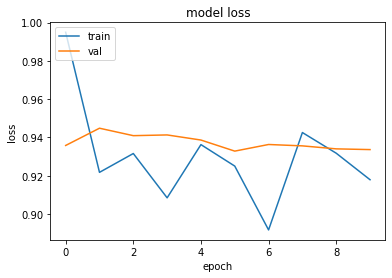

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

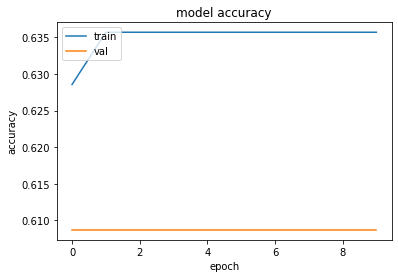

In [35]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [36]:
X_input=np.expand_dims(X_test,axis=2)
ypred=model.predict(X_input)
ypred=np.argmax(ypred, axis=1)
print(classification_report(y_test,ypred))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80        69
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        14

    accuracy                           0.67       103
   macro avg       0.22      0.33      0.27       103
weighted avg       0.45      0.67      0.54       103



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [37]:
plt.plot(butter_bandpass_filter(list[2][1],50,800,4000))

TypeError: ignored

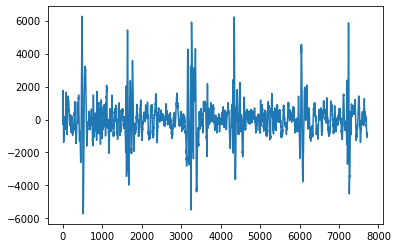

In [0]:
plt.plot(list[2][1])